<a href="https://colab.research.google.com/github/Dih08/projetos-simples-e-aleatorios/blob/main/Token.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resposta a sua pergunta , no modelo anterior a mentora Catarina cita que o mentor iria me mandar um modelo de series temporais para fazer ou modelo pelo menos entendi isso , mas eu criei um aleatório .

Este modelo abrange todo o processo de análise e geração de texto, começando pela leitura e pré-processamento de arquivos de texto. Ele tokeniza o texto e cria sequências n-gram, padronizando para uso em um modelo LSTM. Após construir e treinar o modelo LSTM, ele é utilizado para prever e gerar novas sequências de texto. Além disso, o modelo realiza análise de dados textuais, incluindo remoção de stop words, geração de nuvens de palavras, análise de sentimento e modelagem de tópicos.

Este modelo oferece um fluxo completo desde a leitura e pré-processamento de texto até a geração de novas sequências e análise aprofundada do conteúdo textual.

In [55]:
import os
from zipfile import ZipFile

# Textos de exemplo
text_samples = {
    "book1.txt": "Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do.",
    "book2.txt": "It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.",
    "book3.txt": "Mr. Sherlock Holmes, who was usually very late in the mornings, save upon those not infrequent occasions when he stayed up all night, was seated at the breakfast table.",
    "book4.txt": "Call me Ishmael. Some years ago—never mind how long precisely—having little or no money in my purse, and nothing particular to interest me on shore, I thought I would sail about a little and see the watery part of the world.",
    "book5.txt": "In my younger and more vulnerable years my father gave me some advice that I've been turning over in my mind ever since."
}

# Criar e salvar os arquivos de texto
os.makedirs("books", exist_ok=True)
for filename, content in text_samples.items():
    with open(f"books/{filename}", "w", encoding="utf-8") as file:
        file.write(content)

# Compactar os arquivos em um zip
zip_filename = "books.zip"
with ZipFile(zip_filename, "w") as zipf:
    for filename in text_samples.keys():
        zipf.write(f"books/{filename}")

# Fazer download do arquivo zip
from google.colab import files
files.download(zip_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Este código cria e salva vários arquivos de texto a partir de exemplos fornecidos, os compacta em um arquivo ZIP e faz o download do ZIP.

In [56]:
#deszipando arquivos
!!unzip books.zip -d books/


['Archive:  books.zip',
 'replace books/books/book1.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N']

Deszipei o arquivo


In [58]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Primeiro, importo as bibliotecas necessárias para manipulação de arquivos, processamento de texto, deep learning, e visualização. Em seguida, preparo os dados tokenizando o texto e padronizando as sequências. Crio um modelo sequencial com camadas de Embedding, LSTM e Dense para treinar os dados. Utilizo ferramentas de visualização para analisar e apresentar os dados, como gráficos e nuvens de palavras. Finalmente, aplico técnicas de modelagem de tópicos para identificar padrões nos textos.

In [59]:
# Diretório contendo os arquivos .txt
dataset_path = "books/"  # Caminho do diretório onde os livros foram extraídos


In [60]:
# Carregar os textos do diretório
def load_texts_from_directory(path):
    texts = []
    for filename in os.listdir(path):
        if filename.endswith(".txt"):
            with open(os.path.join(path, filename), "r", encoding="utf-8") as file:
                texts.append(file.read())
    return " ".join(texts)

In [61]:
# Carregar o texto completo do dataset
texts = load_texts_from_directory(dataset_path)

In [62]:
# Pré-processamento básico
def preprocess_text(text):
    # Convert EagerTensor to string before applying string methods
    text = text.numpy().decode("utf-8").lower()
    text = tf.strings.regex_replace(text, "[\\.,!?\\-]", "")  # Remove pontuação
    return text.numpy().decode("utf-8")

texts = preprocess_text(tf.constant(texts))

Convertemos o texto para minúsculas e removemos pontuações usando expressões regulares.

In [63]:
# Tokenização e preparação de sequências
tokenizer = Tokenizer()
tokenizer.fit_on_texts([texts])

total_words = len(tokenizer.word_index) + 1
input_sequences = []

In [64]:
# Criar sequências n-gram
for line in texts.split(". "):  # Divide o texto em frases
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

In [65]:
# Padding das sequências
max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding="pre")

Usamos o Tokenizer para tokenizar o texto e criamos sequências n-gram. Aplicamos padding às sequências para uniformizar o comprimento.

In [66]:
# Divisão em X e y
X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = to_categorical(y, num_classes=total_words)

In [67]:
# Construção do modelo LSTM
model = Sequential([
    Embedding(total_words, 64, input_length=max_sequence_len - 1),
    LSTM(100),
    Dense(total_words, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Treinamento do modelo
history = model.fit(X, y, epochs=250, verbose=1)

Epoch 1/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.0136 - loss: 4.6049
Epoch 2/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.0727 - loss: 4.5936
Epoch 3/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.0572 - loss: 4.5787
Epoch 4/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.0303 - loss: 4.5425
Epoch 5/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 361ms/step - accuracy: 0.0342 - loss: 4.4920
Epoch 6/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.0621 - loss: 4.3880
Epoch 7/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.0696 - loss: 4.3465
Epoch 8/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.1101 - loss: 4.3482
Epoch 9/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.0569 - loss: 4.2378
Epoch 10/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.0633 - loss: 4.2101
Epoch 11/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.0728 - loss: 4.1626
Epoch 12/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy:

Criamos um modelo LSTM com camadas de Embedding e Dense, compilamos e treinamos o modelo com os dados preparados.

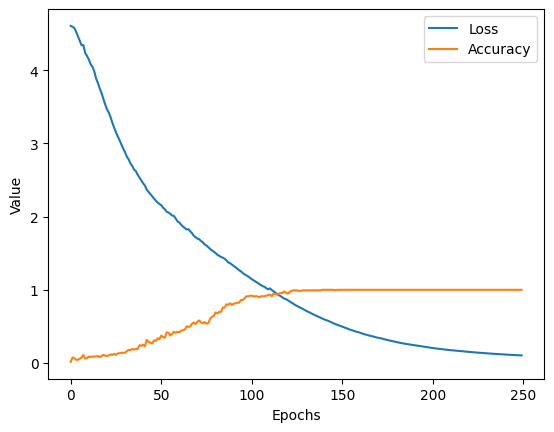

In [69]:
# Gráficos de perda e acurácia
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["accuracy"], label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

Utilizamos o matplotlib para visualizar os gráficos de perda e acurácia durante o treinamento.

In [70]:
# Função para prever a próxima palavra
def predict_next_word(model, tokenizer, text, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding="pre")
    predicted = np.argmax(model.predict(token_list), axis=-1)
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            return word

Criamos uma função para prever a próxima palavra e demonstramos a geração de texto a partir de uma semente inicial.

In [71]:
# Exemplo de geração de texto
seed_text = "Once upon a time"
next_words = 10

In [72]:
for _ in range(next_words):
    next_word = predict_next_word(model, tokenizer, seed_text, max_sequence_len)
    seed_text += " " + next_word

print("Generated text:", seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Generated text: Once upon a time truth universally acknowledged that a single man in possession of


Criamos uma função para prever a próxima palavra e demonstramos a geração de texto a partir de uma semente inicial.
Este processo nos permite gerar novas sequências de texto de maneira iterativa, com base nos padrões aprendidos pelo modelo durante o treinamento.

In [73]:
stop_words = set(stopwords.words("english"))
words = texts.split()
filtered_words = [word for word in words if word not in stop_words]

word_freq = Counter(filtered_words)
print(word_freq.most_common(10))

[('years', 2), ('mind', 2), ('little', 2), ('nothing', 2), ('truth', 1), ('universally', 1), ('acknowledged', 1), ('single', 1), ('man', 1), ('possession', 1)]


Este código ajuda a identificar as palavras mais significativas do texto, excluindo palavras comuns que normalmente não agregam muito valor na análise de dados textuais.

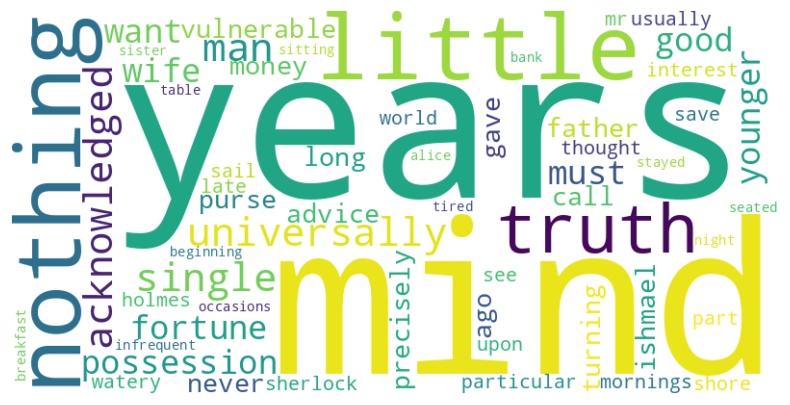

In [74]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Este código ajuda a visualizar a frequência das palavras de maneira gráfica, onde palavras mais frequentes aparecem maiores na nuvem de palavras.

In [75]:
sentiment = TextBlob(texts).sentiment
print(f"Polarity: {sentiment.polarity}, Subjectivity: {sentiment.subjectivity}")

Polarity: -0.04498015873015874, Subjectivity: 0.436468253968254


Polaridade: Mede o grau de positividade ou negatividade do texto, variando de -1 (muito negativo) a 1 (muito positivo).

Subjetividade: Mede o quanto de opinião pessoal ou subjetividade está presente no texto, variando de 0 (muito objetivo) a 1 (muito subjetivo).

Este código permite analisar o sentimento geral do texto combinado, identificando se ele tem um tom mais positivo, negativo, ou neutro, e quão subjetivo ele é.

In [76]:
vectorizer = CountVectorizer(stop_words="english")
doc_term_matrix = vectorizer.fit_transform(texts.split('. '))

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

for i, topic in enumerate(lda.components_):
    print(f"Top words for topic #{i}:")
    print([vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])

Top words for topic #0:
['late', 'long', 'man', 'money', 'mornings', 'mr', 'night', 'occasions', 'precisely', 'younger']
Top words for topic #1:
['money', 'mornings', 'mr', 'night', 'occasions', 'infrequent', 'having', 'little', 'mind', 'years']
Top words for topic #2:
['late', 'long', 'man', 'money', 'mornings', 'mr', 'night', 'occasions', 'precisely', 'younger']
Top words for topic #3:
['late', 'long', 'man', 'money', 'mornings', 'mr', 'night', 'occasions', 'precisely', 'younger']
Top words for topic #4:
['late', 'long', 'man', 'money', 'mornings', 'mr', 'night', 'occasions', 'precisely', 'younger']


Vectorização de Texto: O CountVectorizer converte o texto em uma matriz onde cada entrada representa a contagem de uma palavra no documento.

Modelagem de Tópicos: O LDA identifica um número predefinido de tópicos nos documentos, capturando padrões de co-ocorrência de palavras.

Palavras Principais: Para cada tópico, o código encontra as 10 palavras mais significativas, que ajudam a interpretar o conteúdo dos tópicos identificados.

Este processo permite identificar temas predominantes no texto, utilizando técnicas de NLP (Natural Language Processing).